The **Tox21 data set** comprises of a large number of toxicity measurements for 12 biological targets across a wide range of chemical compounds. For each target, qualitative toxicity assessments are provided, categorizing chemical compounds as either non-toxic (label 0) or toxic (label 1).

The dataset can therefore be considered a collection of twelve parallel datasets, each corresponding to a biological target. For each target, models can be constructed aiming to predict the toxicity (categorical label) of a chemical compound based on its molecular descriptors.

In this notebook, toxicity data for the Nuclear Receptor: Androgen Receptor (NR-AR) is investigated and processed for later model building. The androgen receptor is a protein that is activated by binding an androgenic harmone (such as testosterone) in the cytoplasm of the cell and subsequently translocates to the nucleus, where it binds DNA as a transcription factor to regulate gene expression. 

In [1]:
# Import libraries
import pandas as pd
from rdkit.Chem import Descriptors, PandasTools
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection
import pickle

# display 3 significant digits when printing pandas dataframes
pd.options.display.precision = 3

# path to file
print('Downloading the dataset...')
filepath = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz"
tox_df = pd.read_csv(filepath)
print('Finished\n')

# hide the deprecation warnings from CalcMolDescriptors
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Choose a target
target = "NR-AR"

# create a new dataframe with only data for the biological target of interest
target_tox_df = tox_df.loc[:,[target,"mol_id","smiles"]]
# remove empty cells
target_tox_df = target_tox_df.dropna()
# reset index
target_tox_df = target_tox_df.reset_index(drop=True)

print(f'The total amount of compounds for which labels are available is {len(target_tox_df)}')

Finished

The total amount of compounds for which labels are available is 7265


Notice the data is very imbalanced, which could be a problem when building models:

The number of toxic compounds is 309.0
The number of non-toxic compounds is 6956.0
Percentage of toxic compounds is 4.25%


Text(0.5, 1.0, 'NR-AR')

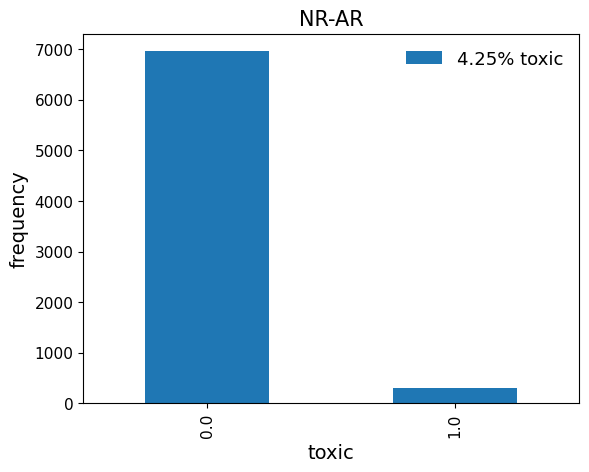

In [2]:
# Calculate the number of toxic and non-toxic compounds
toxic = target_tox_df[target].sum()
nontoxic = len(target_tox_df) - toxic
print(f'The number of toxic compounds is {toxic}')
print(f'The number of non-toxic compounds is {nontoxic}')
print(f'Percentage of toxic compounds is {toxic/len(target_tox_df)*100:.2f}%')

barplt = target_tox_df[target].value_counts().plot.bar(xlabel="toxic",ylabel="frequency",label=f"{toxic/len(target_tox_df)*100:.2f}% toxic")
plt.legend(frameon=False, fontsize=13)
# increase label font size
plt.xlabel("toxic", fontsize=14)
plt.ylabel("frequency", fontsize=14)
# increase label font size
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
#increase title font size
plt.title(target, fontsize=15)


Next, we determine the molecular features that we want to use to build predictive models on. We read in the smiles and calculate molecular descriptors for each compound using RDKit

In [3]:
# add rdkit mol objects to the dataframe
PandasTools.AddMoleculeColumnToFrame(target_tox_df, smilesCol="smiles", molCol='mol_obj')

# calculate all descriptors for all entries
# convert the rdkit mol object column to a list, to iterate over the items more efficiently
mols = target_tox_df.mol_obj.to_list()
# calculate the descriptors using a list comprehension
# this creates a list of dictionaries, which can be easily converted into a dataframe
print('Calculate descriptors...')
tox_desc_list = [Descriptors.CalcMolDescriptors(mol) for mol in mols]
print('Finished')
tox_desc_df = pd.DataFrame(tox_desc_list)
# remove columns containing empty cells
tox_desc_df = tox_desc_df.dropna(axis=1)
# remove constant columns 
tox_desc_df = tox_desc_df.loc[:,tox_desc_df.apply(pd.Series.nunique) != 1]
# record the names of the descriptors from RDKit
param = tox_desc_df.columns

Calculate descriptors...
Finished


We calculate the correlation matrix between all the molecular descriptors as well as the target label and sort by those correlating strongest to the label.

In [4]:
# calculate the correlation matrix
# create a new dataframe with the descriptors and the label
tox_df_new = tox_desc_df.copy()
# create a copy of the responce variable columns for the label of choice
tox_df_new[target] = target_tox_df[target]
tox_corrmat = tox_df_new.corr()
tox_corrmat = tox_corrmat.sort_values(by=target, ascending=False, key=abs, axis=0)
tox_corrmat = tox_corrmat.sort_values(by=target, ascending=False, key=abs, axis=1)
print(tox_corrmat.head(5))
#save the correlation matrix
tox_corrmat.to_csv('tox_corrmat.csv')

                         NR-AR  NumAliphaticCarbocycles  \
NR-AR                    1.000                    0.453   
NumAliphaticCarbocycles  0.453                    1.000   
NumSaturatedCarbocycles  0.417                    0.919   
fr_bicyclic              0.369                    0.622   
SMR_VSA4                 0.343                    0.714   

                         NumSaturatedCarbocycles  fr_bicyclic  SMR_VSA4  \
NR-AR                                      0.417        0.369     0.343   
NumAliphaticCarbocycles                    0.919        0.622     0.714   
NumSaturatedCarbocycles                    1.000        0.551     0.717   
fr_bicyclic                                0.551        1.000     0.527   
SMR_VSA4                                   0.717        0.527     1.000   

                           SPS  SlogP_VSA4  fr_ketone  NumAliphaticRings  \
NR-AR                    0.321       0.303      0.296              0.292   
NumAliphaticCarbocycles  0.727       0.609

From the correlation matrix it is clear that
- Many indicators of hydrophobic groups are correlated to the NR-AR label
- The molecular features have very strong multicollinearities, evident from the high correlation coefficients of the features to each other.

We split the data set in Train and Test Data using stratisfied splitting to ensure the minority class (toxic) is well-represented in both sets.

In [7]:
# Split in Train and Test sets
train_ind, test_ind, y_train, y_test = model_selection.train_test_split(target_tox_df.index, target_tox_df[target], test_size=0.2, stratify=target_tox_df[target], random_state=17)
X_train = tox_desc_df.loc[train_ind,:].to_numpy()
X_test = tox_desc_df.loc[test_ind,:].to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Also record the corresponding train and test smiles and mol_id
train_smi = target_tox_df.loc[train_ind,"smiles"].to_list()
test_smi = target_tox_df.loc[test_ind,"smiles"].to_list()
train_mol_id = target_tox_df.loc[train_ind,"mol_id"].to_list()
test_mol_id = target_tox_df.loc[test_ind,"mol_id"].to_list()

We remove features that
- have low variance (after min-max scaling) 
- AND are weakly correlated to the NR-AR label

In [8]:
from sklearn.preprocessing import MinMaxScaler

# apply a min-max range scaler, then calculate the variances of the scaled descriptors on training set
scaler_minmax = MinMaxScaler().fit(X_train)
df_train_minmax = pd.DataFrame(scaler_minmax.transform(X_train), columns=param)
scaled_var = df_train_minmax.var()

# get the correlation of the descriptors to the target
corr_tox = np.array([tox_corrmat[feat].iloc[0] for feat in param])
print(f'X_train before removing constant columns: {X_train.shape}')

# set the threshold for the variance
variance_threshold = 0.002
# check which parameters have a variance higher than the threshold or a correlation to the target higher than 0.1
train_var_over_thresh = (scaled_var > variance_threshold) | (abs(corr_tox) > 0.1)
# check which parameters have a variance lower than the threshold
rem_param = param[~train_var_over_thresh].to_list()
print(f'Removed parameters = {rem_param}')

# remove the selected columns from the training and test sets
X_train = X_train[:,train_var_over_thresh]
X_test = X_test[:,train_var_over_thresh]
param = param[train_var_over_thresh]
param = param.to_list()
print(f'X_train after removing constants columns: {X_train.shape}')

X_train before removing constant columns: (5812, 194)
Removed parameters = ['NumRadicalElectrons', 'Ipc', 'Kappa2', 'Kappa3', 'PEOE_VSA13', 'PEOE_VSA14', 'SMR_VSA9', 'SlogP_VSA11', 'VSA_EState1', 'VSA_EState10', 'VSA_EState4', 'VSA_EState5', 'VSA_EState7', 'VSA_EState9', 'NumAliphaticHeterocycles', 'NumSaturatedHeterocycles', 'MolLogP', 'fr_Ar_OH', 'fr_N_O', 'fr_Ndealkylation1', 'fr_SH', 'fr_alkyl_carbamate', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_epoxide', 'fr_guanido', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_priamide', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene']
X_train after removing constants columns: (5812, 153)


In [9]:
# Save as pickle
print(f'Saving the processed data to {target}_processeddata.pkl')
pickle_out = open(target+"_processeddata.pkl", "wb")
processeddata_content = [param, train_smi, test_smi, train_mol_id, test_mol_id,  X_train, X_test, y_train, y_test]
pickle.dump(processeddata_content, pickle_out)
pickle_out.close()

Saving the processed data to NR-AR_processeddata.pkl


In conclusion, we note the following observations which might complicate building predictive models:
- The data set is very imbalanced (only 4.25\% of samples is categorized as toxic)
- The molecular features are highly collinear.